In [30]:
import numpy as np
import pandas as pd
from numpy import array
from numpy import cumsum
import matplotlib.pyplot as plt


import multiprocessing
from tqdm import tqdm

# from spam
from collections import Counter


# keras
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Embedding, Input
from keras.layers import Embedding, Flatten, Activation, RepeatVector, Permute, multiply, Lambda
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score, classification_report

In [2]:
X_train = pd.read_csv('../X_train.csv')
X_test = pd.read_csv('../X_test.csv')

In [3]:
X_train = X_train.dropna()
X_train.isnull().sum()

tokenized_text    0
mental_state      0
dtype: int64

In [4]:
X_test = X_test.dropna()
X_test.isnull().sum()

tokenized_text    0
mental_state      0
dtype: int64

In [5]:
X_test.reset_index(inplace = True)
X_train.reset_index(inplace = True)

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X_train['tokenized_text']))
list_tokenized_train = tokenizer.texts_to_sequences(X_train['tokenized_text'])
list_tokenized_test = tokenizer.texts_to_sequences(X_test['tokenized_text'])

In [7]:
pad_train = pad_sequences(list_tokenized_train, maxlen=150, padding='post')
pad_test = pad_sequences(list_tokenized_test, maxlen=150, padding='post')

In [8]:
y_target = pd.get_dummies(X_train['mental_state']).values
y_target_test = pd.get_dummies(X_test['mental_state']).values

In [9]:
vocab_size = len(tokenizer.word_index)+1

## Glove

In [10]:
# import zipfile
# with zipfile.ZipFile('../glove.42B.300d.zip', 'r') as zip_ref:
#     zip_ref.extractall('../glove.42B.300d')

In [11]:
embedding_vector = {}
f = open('../glove.42B.300d/glove.42B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

1917495it [01:54, 16712.26it/s]


In [12]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(tokenizer.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 257265/257265 [00:00<00:00, 399550.19it/s]


## LSTM with Attention

https://stackoverflow.com/questions/42918446/how-to-add-an-attention-mechanism-in-keras

In [15]:
units = 64

_input = Input(shape=(pad_train.shape[1],), dtype='int64')

# get the embedding layer
embedded = Embedding(vocab_size,300,weights = [embedding_matrix],input_length=150,trainable = False)(_input)

activations = LSTM(units, return_sequences=True)(embedded)

# compute importance for each step
attention = TimeDistributed(Dense(1, activation='tanh'))(activations) 
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

# apply the attention
sent_representation = multiply([activations, attention])
sent_representation = Lambda(lambda xin: backend.sum(xin, axis=2), output_shape=(units,))(sent_representation)
sent_representation = Flatten()(sent_representation)

probabilities = Dense(3, activation='softmax')(sent_representation)

model = Model(inputs=_input, outputs=probabilities)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 150, 300)     77179800    input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 150, 64)      93440       embedding_1[0][0]                
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 150, 1)       65          lstm_1[0][0]                     
_______________________________________________________________________________________

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history = model.fit(pad_train, y_target, batch_size=256, epochs=10, validation_split=0.1, verbose=1, callbacks = [es])

Epoch 1/10
5153/5153 [==============================] - 1958s 380ms/step - loss: 0.5910 - accuracy: 0.7396 - val_loss: 0.5344 - val_accuracy: 0.7662
Epoch 2/10
5153/5153 [==============================] - 1959s 380ms/step - loss: 0.5170 - accuracy: 0.7727 - val_loss: 0.5011 - val_accuracy: 0.7801
Epoch 3/10
5153/5153 [==============================] - 1976s 383ms/step - loss: 0.4943 - accuracy: 0.7829 - val_loss: 0.4933 - val_accuracy: 0.7840
Epoch 4/10
5153/5153 [==============================] - 1984s 385ms/step - loss: 0.4866 - accuracy: 0.7867 - val_loss: 0.4867 - val_accuracy: 0.7873
Epoch 5/10
5153/5153 [==============================] - 2020s 392ms/step - loss: 0.4744 - accuracy: 0.7923 - val_loss: 0.4848 - val_accuracy: 0.7879
Epoch 6/10
5153/5153 [==============================] - 2035s 395ms/step - loss: 0.4686 - accuracy: 0.7951 - val_loss: 0.4808 - val_accuracy: 0.7892
Epoch 7/10
5153/5153 [==============================] - 2043s 396ms/step - loss: 0.4609 - accuracy: 0.7986

In [21]:
model.save("../model_lstmAttention_10_epoch.h5")

In [ ]:
from tensorflow import keras
model = keras.models.load_model("../model_lstmAttention_10_epoch.h5")

In [22]:
def performance(y_true, y_hat):
    
    y_true = list(map(lambda x: np.argmax(x), y_true))
    y_hat = list(map(lambda x: np.argmax(x), y_hat))
    
    y_true_roc = pd.DataFrame(y_true, columns = ['mental_state'])
    y_hat_roc = pd.DataFrame(y_hat, columns = ['mental_state'])
    
    y_true_roc = pd.get_dummies(y_true_roc['mental_state']).values
    y_hat_roc = pd.get_dummies(y_hat_roc['mental_state']).values
    
    # result template
    print('-'*40+' Result Report '+'-'*40)
    
    # Accuracy
    print('Accuracy: ', accuracy_score(y_true,y_hat))
    
    # Confusion matrix
    print('\n')
    print('Confusion Matrix: \n', confusion_matrix(y_true,y_hat))
    print('\n')

    # Classification Report
    print('Classification Report: \n')
    print(classification_report(y_true, y_hat))
    print('\n')
    
    # Aggregated area under the ROC curve
    print('Area under ROC curve: ', roc_auc_score(y_true_roc, y_hat_roc, multi_class='ovo'))
    
    print('-'*95)

### Result

In [24]:
predictions = model.predict(pad_test)

In [27]:
performance(y_target_test, predictions)

---------------------------------------- Result Report ----------------------------------------
Accuracy:  0.792497884998499


Confusion Matrix: 
 [[ 97199   8745   2018]
 [  9742 135081  23302]
 [  4373  27855  58115]]


Classification Report: 

              precision    recall  f1-score   support

           0       0.87      0.90      0.89    107962
           1       0.79      0.80      0.80    168125
           2       0.70      0.64      0.67     90343

    accuracy                           0.79    366430
   macro avg       0.79      0.78      0.78    366430
weighted avg       0.79      0.79      0.79    366430



Area under ROC curve:  0.8360248798168861
-----------------------------------------------------------------------------------------------


### Plot the history result to check for overfit

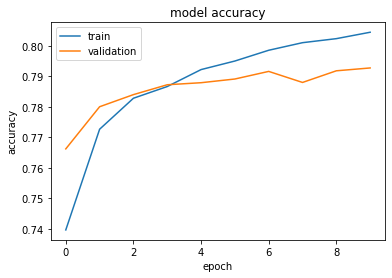

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

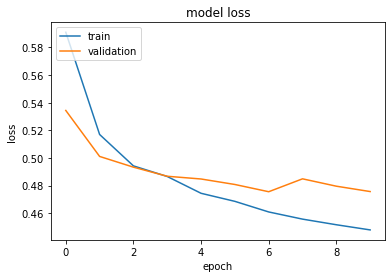

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:
def check_mental_state(model, post, tokenizer):
    
    dic_state = {0:'Normal', 1:'Depressed', 2:'Suicidal'}
    
    SET_LIMIT_SENTENCE = 150
    
    print('Post: \n')
    print(post)
    print('\n')
    
    list_post = [post]
    list_post_tokenized = tokenizer.texts_to_sequences(list_post)
    post_pad = pad_sequences(list_post_tokenized, maxlen=SET_LIMIT_SENTENCE, padding='post')
    
    # classify mental state
    mental_state = model.predict(post_pad)
    
    print('Normal: ', str(round(mental_state[0][0], 2)*100)+'%')
    print('Depressed: ', str(round(mental_state[0][1], 2)*100)+'%')
    print('Suicidal: ', str(round(mental_state[0][2], 2)*100)+'%')
    
    classify_state = np.argmax(mental_state[0])
    #list(map(lambda x: np.argmax(x), mental_state))
    
    print('\n')
    print('Model Classify: ', dic_state[classify_state])

In [37]:
post = X_test[X_test['mental_state']==2]['tokenized_text'][19]
check_mental_state(model, post, tokenizer)

Post: 

i know i tried everything guys i gone different psychologists types anti depressants i made effort get bed every day walk my dog go gym read distant feeling increases exponentially day i never really loved life i loved people it lately spark disappeared i connect anyone fine i even connect my parents kills me inside i want stop mundane cycle my life become initially i told myself i stick it them i longer hold restrictions i always tried my best persevere keep looking forward i cried day today i realized threshold kept me taking action disappeared i want it feel selfish even thoughts somewhere i smiled loved i feel outcome inevitable please help


Normal:  0.0%
Depressed:  52.99999713897705%
Suicidal:  46.00000083446503%


Model Classify:  Depressed


In [38]:
post = X_test[X_test['mental_state']==0]['tokenized_text'][2]
check_mental_state(model, post, tokenizer)

Post: 

cc room get enough love time day come play some music hang cc room great way find new music chatting lovely people we got people room we would love come party us follow link https hit headphones sidebar go room you need sign you account already it quick easy


Normal:  98.00000190734863%
Depressed:  1.9999999552965164%
Suicidal:  0.0%


Model Classify:  Normal


In [39]:
post = X_test[X_test['mental_state']==1]['tokenized_text'][366423]
check_mental_state(model, post, tokenizer)

Post: 

i suicidal thoughts first time i suicidal thoughts i able speak my problems end my parents finally took me psychologist they always said i lazy lot sad things happened my grandfather passed away i terribly low i feeling hopeful barely suicidal thoughts still confidence months back my parents started arguing lot leading divorce my mom lied much got me stressed point i ca sleep night i also started going gym improve my i feel tired i think i give warning might trigger i tried commit suicide times never told my parents mostly tried hanging myself i always wanted die quickly last night i tried cut myself never thought i would i scared i might myself my psychologist vacation i feel guilty make my parents waste money me i think i deserve it i getting distant my friends i want hurt them i kill myself i trying keep my mind busy arguing making me stressed every day it seems like one end me amp amp


Normal:  0.0%
Depressed:  43.00000071525574%
Suicidal:  56.99999928474426%


Model Class